In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys 
sys.path.append('/content/drive/My Drive/Reuters/')

In [3]:
import DataPreprogress
import SSNMF_Reuters_t
from SSNMF_Reuters_t import SSNMF_Reuters_t
import SSNMF_torch
from SSNMF_torch import SSNMF_torch
import nltk
from nltk.corpus import reuters
nltk.download('reuters')
nltk.download('stopwords')
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

Streaming output truncated to the last 5000 lines.
  inflating: /root/nltk_data/corpora/reuters/training/2231  
  inflating: /root/nltk_data/corpora/reuters/training/2232  
  inflating: /root/nltk_data/corpora/reuters/training/2234  
  inflating: /root/nltk_data/corpora/reuters/training/2236  
  inflating: /root/nltk_data/corpora/reuters/training/2237  
  inflating: /root/nltk_data/corpora/reuters/training/2238  
  inflating: /root/nltk_data/corpora/reuters/training/2239  
  inflating: /root/nltk_data/corpora/reuters/training/2240  
  inflating: /root/nltk_data/corpora/reuters/training/2244  
  inflating: /root/nltk_data/corpora/reuters/training/2246  
  inflating: /root/nltk_data/corpora/reuters/training/2247  
  inflating: /root/nltk_data/corpora/reuters/training/2249  
  inflating: /root/nltk_data/corpora/reuters/training/225  
  inflating: /root/nltk_data/corpora/reuters/training/2251  
  inflating: /root/nltk_data/corpora/reuters/training/2252  
  inflating: /root/nltk_data/corpor

In [5]:
# Extract fileids from the reuters corpus
file_ids = reuters.fileids()
torch.set_printoptions(precision=10)
trn_data, tst_data, trn_labels, tst_labels, cuda0 = DataPreprogress.load_data(file_ids)
X_trn, X_tst = DataPreprogress.get_tfidf_matrices(trn_data, tst_data, max_feature = 600, cuda_device = cuda0)
#X_trn, trn_labels = DataPreprogress.shuffle(X_trn, trn_labels)
#X_tst, tst_labels = DataPreprogress.shuffle(X_tst, tst_labels)

GPU not available. Currently using CPU. In Google Colab Please set GPU via Edit -> Notebook Settings.


In [6]:
def get_lables_prediction(test_labels_approx, threshold):
  for i in range(test_labels_approx.size(1)):
    max = torch.max(test_labels_approx[:,i])
    min = torch.min(test_labels_approx[:,i])
    r = max - min
    test_labels_approx[:,i] = test_labels_approx[:,i] >= (min + threshold*r)
  return test_labels_approx

In [7]:
def threshold_analysis(exp,threshold_list):
  err = exp.eval()
  true_positive_rate_list = []
  false_positive_rate_list = []
  micro_F1_list = []

  for i in range(len(threshold_list)):
      test_labels_approx = exp.model.B @ exp.S_test
      pred_labels = get_lables_prediction(test_labels_approx, threshold_list[i])
      true_positive_rate = 0
      false_positive_rate = 0
      precision = 0
      sum_t_p = 0
      sum_f_p = 0
      sum_t_n = 0
      sum_f_n = 0
      for j in range(pred_labels.size(0)):
          confusion_vector = pred_labels[j]/tst_labels[j]

          t_p = torch.sum(confusion_vector == 1).item()
          f_p = torch.sum(confusion_vector == float('inf')).item()
          t_n = torch.sum(torch.isnan(confusion_vector)).item()
          f_n = torch.sum(confusion_vector == 0).item()

          sum_t_p = sum_t_p + t_p
          sum_f_p = sum_f_p + f_p
          sum_t_n = sum_t_n + t_n
          sum_f_n = sum_f_n + f_n

          true_positive_rate = true_positive_rate + t_p/(t_p + f_n)
          false_positive_rate = false_positive_rate + f_p/(f_p + t_n)

      true_positive_rate_list.append(true_positive_rate/90)
      false_positive_rate_list.append(false_positive_rate/90)

      micro_precision = sum_t_p/(sum_t_p + sum_f_p)
      micro_recall = sum_t_p/(sum_t_p + sum_f_n)
      
      micro_F1 = 2*(micro_precision * micro_recall)/(micro_precision + micro_recall)
      micro_F1_list.append(micro_F1)

  return true_positive_rate_list, false_positive_rate_list, micro_F1_list


In [8]:
def show_analysis_results(threshold_list, true_positive_rate_list, false_positive_rate_list, micro_F1_list):
  df = pd.DataFrame({
      "threshold(%)":threshold_list,
      "true_positive_rate":true_positive_rate_list,
      "false_positive_rate":false_positive_rate_list,
      "micro_F1_score":micro_F1_list
  })
  return df

In [9]:
def plot_roc(true_positive_rate_list, false_positive_rate_list):
  plt.figure()
  lw = 2
  plt.plot(false_positive_rate_list, true_positive_rate_list, marker='o', color='darkorange',
          lw=lw, label='ROC curve')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('thresholds&ROC')
  plt.legend(loc="lower right")
  plt.show()

  auc = metrics.auc(np.array(false_positive_rate_list), np.array(true_positive_rate_list))
  return auc

In [10]:
def plot_micro_F1(threshold_list,micro_F1_list):
  plt.figure()
  lw = 2
  plt.plot(threshold_list, micro_F1_list, marker='o', color='darkorange',
          lw=lw, label='micro_F1 curve')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1])
  plt.ylim([0.0, 1.05])
  plt.xlabel('thresholds')
  plt.ylabel('micro F1 scores')
  plt.title('micro F1')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:

exp_4 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=20, modelNum=4)
exp_5 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=20, modelNum=5)
exp_6 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=20, modelNum=6)

In [11]:
thresholds_list = [i/10000 for i in range(1,10)] + \
                  [i/100000 for i in range(100,200, 25)] + \
                  [i/1000 for i in range(2,10)] + \
                  [i/10000 for i in range(100,200, 25)] + \
                  [i/100 for i in range(2,10)] + \
                  [i/10 for i in range(1,10)]

In [ ]:
exp_3 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=500, modelNum=3)
t_p_r_3, f_p_r_3, micro_F1_3 = threshold_analysis(exp_3, thresholds_list)

In [ ]:
show_analysis_results(thresholds_list, t_p_r_3, f_p_r_3, micro_F1_3)

,threshold(%),true_positive_rate,false_positive_rate,micro_F1_score
0,0.00010,0.907695,0.806944,0.033305
1,0.00020,0.876064,0.756329,0.035392
2,0.00030,0.867787,0.722176,0.036968
3,0.00040,0.861396,0.695702,0.038260
4,0.00050,0.845156,0.673801,0.039389
5,0.00060,0.841536,0.654987,0.040426
6,0.00070,0.834657,0.638729,0.041384
7,0.00080,0.831371,0.624271,0.042260
8,0.00090,0.819651,0.611398,0.043079
9,0.00100,0.795172,0.599597,0.043797


In [ ]:
t_p_r_3 = [1] + t_p_r_3 + [0]
f_p_r_3 = [1] + f_p_r_3 + [0]

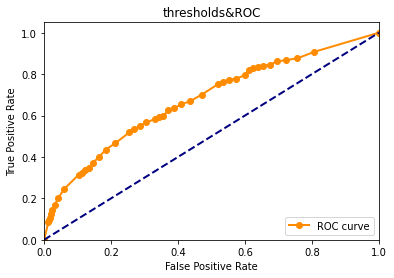

0.6764298351522445

In [ ]:
plot_roc(t_p_r_3, f_p_r_3)

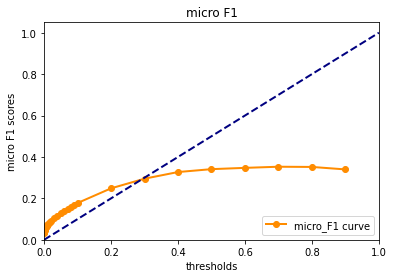

In [ ]:
plot_micro_F1(thresholds_list,micro_F1_3)

In [12]:
k_vals = [100,200,500]
lambda_vals = [1, 10, 50, 100]
iter_vals = [10,100,1000]

f1_scores = np.zeros([np.shape(k_vals)[0],np.shape(lambda_vals)[0],np.shape(iter_vals)[0]])

In [52]:
for i in range(np.shape(k_vals)[0]):
  for j in range(np.shape(lambda_vals)[0]):
    for l in range(np.shape(iter_vals)[0]):
      print(i,j,l)
      k = k_vals[i]
      lam = lambda_vals[j]
      iters = iter_vals[l]

      exp_5 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=k, modelNum=5, lam = lam, iter_s = iters)
      t_p_r_5, f_p_r_5, micro_F1_5 = threshold_analysis(exp_5, thresholds_list)
      f1_scores[i,j,l] = max(micro_F1_5)

0 0 0
ours:  0.029271003314510668
sklearn:  0.029271003314510668
ours:  0.02997348437744447
sklearn:  0.02997348437744447
ours:  0.03056620291017087
sklearn:  0.03056620291017087
ours:  0.03110668660471432
sklearn:  0.03110668660471432
ours:  0.03157957103922266
sklearn:  0.03157957103922266
ours:  0.03203360564904776
sklearn:  0.03203360564904776
ours:  0.0324648739993554
sklearn:  0.0324648739993554
ours:  0.03288167012402348
sklearn:  0.03288167012402348
ours:  0.033260800600517414
sklearn:  0.033260800600517414
ours:  0.033645519131366756
sklearn:  0.033645519131366756
ours:  0.03453274849453572
sklearn:  0.03453274849453572
ours:  0.03537884128103031
sklearn:  0.03537884128103031
ours:  0.03615691398593898


KeyboardInterrupt: ignored

In [29]:
f1_scores[1,0,0]

0.41851632047477744

In [15]:
num_trials = 20

results_3 = np.zeros([1,5*num_trials])
results_4 = np.zeros([1,5*num_trials])
results_5 = np.zeros([1,5*num_trials])
results_6 = np.zeros([1,5*num_trials])

for i in range(num_trials):
  print(i)
  exp_3 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=3, lam = 1, iter_s = 10)
  t_p_r_3, f_p_r_3, micro_F1_3 = threshold_analysis(exp_3, thresholds_list)
  #print("Model 3: ", max(micro_F1_3))
  results_3[0,i] = max(micro_F1_3)

  exp_4 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=4, lam = 1, iter_s = 10)
  t_p_r_4, f_p_r_4, micro_F1_4 = threshold_analysis(exp_4, thresholds_list)
  #print("Model 4: ", max(micro_F1_4))
  results_4[0,i] = max(micro_F1_4)

  exp_5 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=5, lam = 1, iter_s = 10)
  t_p_r_5, f_p_r_5, micro_F1_5 = threshold_analysis(exp_5, thresholds_list)
  #print("Model 5: ", max(micro_F1_5))
  results_5[0,i] = max(micro_F1_5)

  exp_6 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=6, lam = 1, iter_s = 10)
  t_p_r_6, f_p_r_6, micro_F1_6 = threshold_analysis(exp_6, thresholds_list)
  #print("Model 6: ", max(micro_F1_6))
  results_6[0,i] = max(micro_F1_6)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [16]:
print(np.mean(results_3))
print(np.std(results_3))
print(np.mean(results_4))
print(np.std(results_4))
print(np.mean(results_5))
print(np.std(results_5))
print(np.mean(results_6))
print(np.std(results_6))

0.08204747609057594
0.16422311393415545
0.0673240674455837
0.13490856985572133
0.07569545875697205
0.1515581426328899
0.07415018979810518
0.148769791985214


In [17]:
num_trials = 20

for i in range(20,20+num_trials):
  print(i)
  exp_3 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=3, lam = 1, iter_s = 10)
  t_p_r_3, f_p_r_3, micro_F1_3 = threshold_analysis(exp_3, thresholds_list)
  #print("Model 3: ", max(micro_F1_3))
  results_3[0,i] = max(micro_F1_3)

  exp_4 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=4, lam = 1, iter_s = 10)
  t_p_r_4, f_p_r_4, micro_F1_4 = threshold_analysis(exp_4, thresholds_list)
  #print("Model 4: ", max(micro_F1_4))
  results_4[0,i] = max(micro_F1_4)

  exp_5 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=5, lam = 1, iter_s = 10)
  t_p_r_5, f_p_r_5, micro_F1_5 = threshold_analysis(exp_5, thresholds_list)
  #print("Model 5: ", max(micro_F1_5))
  results_5[0,i] = max(micro_F1_5)

  exp_6 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=6, lam = 1, iter_s = 10)
  t_p_r_6, f_p_r_6, micro_F1_6 = threshold_analysis(exp_6, thresholds_list)
  #print("Model 6: ", max(micro_F1_6))
  results_6[0,i] = max(micro_F1_6)

20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [18]:
print(np.mean(results_3))
print(np.std(results_3))
print(np.mean(results_4))
print(np.std(results_4))
print(np.mean(results_5))
print(np.std(results_5))
print(np.mean(results_6))
print(np.std(results_6))

0.1651037991255256
0.20238012090501928
0.1364816040154518
0.16754581757303702
0.15130175851559258
0.18571870083459138
0.14908074902495086
0.1832296866960122


In [19]:
num_trials = 20

for i in range(40,40+num_trials):
  print(i)
  exp_3 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=3, lam = 1, iter_s = 10)
  t_p_r_3, f_p_r_3, micro_F1_3 = threshold_analysis(exp_3, thresholds_list)
  #print("Model 3: ", max(micro_F1_3))
  results_3[0,i] = max(micro_F1_3)

  exp_4 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=4, lam = 1, iter_s = 10)
  t_p_r_4, f_p_r_4, micro_F1_4 = threshold_analysis(exp_4, thresholds_list)
  #print("Model 4: ", max(micro_F1_4))
  results_4[0,i] = max(micro_F1_4)

  exp_5 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=5, lam = 1, iter_s = 10)
  t_p_r_5, f_p_r_5, micro_F1_5 = threshold_analysis(exp_5, thresholds_list)
  #print("Model 5: ", max(micro_F1_5))
  results_5[0,i] = max(micro_F1_5)

  exp_6 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=6, lam = 1, iter_s = 10)
  t_p_r_6, f_p_r_6, micro_F1_6 = threshold_analysis(exp_6, thresholds_list)
  #print("Model 6: ", max(micro_F1_6))
  results_6[0,i] = max(micro_F1_6)

40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [20]:
print(np.mean(results_3))
print(np.std(results_3))
print(np.mean(results_4))
print(np.std(results_4))
print(np.mean(results_5))
print(np.std(results_5))
print(np.mean(results_6))
print(np.std(results_6))

0.24931204237929472
0.20383953529846535
0.205999515303576
0.16874640235025146
0.22783572960958406
0.18668195435528073
0.22192280145700632
0.18225322974982583


In [21]:
num_trials = 20

for i in range(60,60+num_trials):
  print(i)
  exp_3 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=3, lam = 1, iter_s = 10)
  t_p_r_3, f_p_r_3, micro_F1_3 = threshold_analysis(exp_3, thresholds_list)
  #print("Model 3: ", max(micro_F1_3))
  results_3[0,i] = max(micro_F1_3)

  exp_4 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=4, lam = 1, iter_s = 10)
  t_p_r_4, f_p_r_4, micro_F1_4 = threshold_analysis(exp_4, thresholds_list)
  #print("Model 4: ", max(micro_F1_4))
  results_4[0,i] = max(micro_F1_4)

  exp_5 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=5, lam = 1, iter_s = 10)
  t_p_r_5, f_p_r_5, micro_F1_5 = threshold_analysis(exp_5, thresholds_list)
  #print("Model 5: ", max(micro_F1_5))
  results_5[0,i] = max(micro_F1_5)

  exp_6 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=6, lam = 1, iter_s = 10)
  t_p_r_6, f_p_r_6, micro_F1_6 = threshold_analysis(exp_6, thresholds_list)
  #print("Model 6: ", max(micro_F1_6))
  results_6[0,i] = max(micro_F1_6)

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [22]:
print(np.mean(results_3))
print(np.std(results_3))
print(np.mean(results_4))
print(np.std(results_4))
print(np.mean(results_5))
print(np.std(results_5))
print(np.mean(results_6))
print(np.std(results_6))

0.3326756022880656
0.1668142225857422
0.2754094050467379
0.138688487527411
0.3039482890596114
0.1530103325234538
0.295838360848978
0.1496761183610962


In [23]:
num_trials = 20

for i in range(80,80+num_trials):
  print(i)
  exp_3 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=3, lam = 1, iter_s = 10)
  t_p_r_3, f_p_r_3, micro_F1_3 = threshold_analysis(exp_3, thresholds_list)
  #print("Model 3: ", max(micro_F1_3))
  results_3[0,i] = max(micro_F1_3)

  exp_4 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=4, lam = 1, iter_s = 10)
  t_p_r_4, f_p_r_4, micro_F1_4 = threshold_analysis(exp_4, thresholds_list)
  #print("Model 4: ", max(micro_F1_4))
  results_4[0,i] = max(micro_F1_4)

  exp_5 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=5, lam = 1, iter_s = 10)
  t_p_r_5, f_p_r_5, micro_F1_5 = threshold_analysis(exp_5, thresholds_list)
  #print("Model 5: ", max(micro_F1_5))
  results_5[0,i] = max(micro_F1_5)

  exp_6 = SSNMF_Reuters_t(X_trn, trn_labels, X_tst, tst_labels, k=200, modelNum=6, lam = 1, iter_s = 10)
  t_p_r_6, f_p_r_6, micro_F1_6 = threshold_analysis(exp_6, thresholds_list)
  #print("Model 6: ", max(micro_F1_6))
  results_6[0,i] = max(micro_F1_6)

80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [24]:
print(np.mean(results_3))
print(np.std(results_3))
print(np.mean(results_4))
print(np.std(results_4))
print(np.mean(results_5))
print(np.std(results_5))
print(np.mean(results_6))
print(np.std(results_6))

0.4158518014172893
0.013798380306190603
0.34459871763122357
0.017601983650849164
0.3814992897217435
0.02082835692193277
0.368595077790386
0.025060074331753415
